In [2]:
import os

import pandas as pd
import xgboost as xgb

C:\Users\miiki\Desktop\DATA_SCIENCE\APRENDIZAJE_PYTHON\venvs\Nuclio\env_nuclio\Lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
print(f"pandas version: {pd.__version__}")
print(f"xgboost version: {xgb.__version__}")

pandas version: 1.5.1
xgboost version: 1.3.3


In [4]:
import pickle
import os

from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder


# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

In [5]:
print("Working with these versions of libraries\n")
print("-"*50)
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

--------------------------------------------------
Numpy version 1.26.4
Pandas version 1.5.1
XGBoost version 1.3.3


In [6]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "data")

# DATA_PATH = ""

FILE_NAME = "ts_kaggle_train.csv"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

In [7]:
DATA_PATH

'C:\\Users\\miiki\\Desktop\\DATA_SCIENCE\\APRENDIZAJE_PYTHON\\venvs\\Nuclio\\notebooks\\time_series\\Entregable_3_Benchmark\\data'

In [8]:
df= pd.read_csv(TRAIN_CSV_PATH,index_col=0)

In [9]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0


In [10]:
df['date']= pd.to_datetime(df['date'], format='%Y-%m-%d')

In [11]:
# conocer fechas unicas. 33 para entrenar 1 para predecir
df['date'].nunique()

34

In [12]:
df['date'].unique()

array(['2013-01-31T00:00:00.000000000', '2013-02-28T00:00:00.000000000',
       '2013-03-31T00:00:00.000000000', '2013-04-30T00:00:00.000000000',
       '2013-05-31T00:00:00.000000000', '2013-06-30T00:00:00.000000000',
       '2013-07-31T00:00:00.000000000', '2013-08-31T00:00:00.000000000',
       '2013-09-30T00:00:00.000000000', '2013-10-31T00:00:00.000000000',
       '2013-11-30T00:00:00.000000000', '2013-12-31T00:00:00.000000000',
       '2014-01-31T00:00:00.000000000', '2014-02-28T00:00:00.000000000',
       '2014-03-31T00:00:00.000000000', '2014-04-30T00:00:00.000000000',
       '2014-05-31T00:00:00.000000000', '2014-06-30T00:00:00.000000000',
       '2014-07-31T00:00:00.000000000', '2014-08-31T00:00:00.000000000',
       '2014-09-30T00:00:00.000000000', '2014-10-31T00:00:00.000000000',
       '2014-11-30T00:00:00.000000000', '2014-12-31T00:00:00.000000000',
       '2015-01-31T00:00:00.000000000', '2015-02-28T00:00:00.000000000',
       '2015-03-31T00:00:00.000000000', '2015-04-30

In [13]:
# Series temproales únicas
df['unique_id'].nunique()

426

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14484 non-null  datetime64[ns]
 1   unique_id              14484 non-null  object        
 2   city_id                14484 non-null  int64         
 3   shop_id                14484 non-null  int64         
 4   item_category_id       14484 non-null  int64         
 5   item_id                14484 non-null  int64         
 6   monthly_average_price  13262 non-null  float64       
 7   monthly_sales          13756 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1018.4+ KB


In [15]:
df.describe()

,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
count,14484.000000,14484.000000,14484.000000,14484.000000,13262.000000,13756.000000
mean,10.833333,31.967136,39.356808,8626.431925,916.089314,7.337889
std,6.227364,15.236351,20.439654,5905.273346,820.945949,7.915032
min,0.000000,3.000000,2.000000,32.000000,4.928571,0.000000
25%,7.000000,22.000000,30.000000,4248.000000,299.000000,2.000000
50%,7.000000,31.000000,35.000000,6457.000000,649.000000,5.000000
75%,16.000000,44.000000,55.000000,12551.000000,1149.000000,9.000000
max,23.000000,59.000000,83.000000,22088.000000,9305.121212,30.000000


In [16]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

Df de ventas, un caso transaccional. En este caso yo puedo identificar nulos de 2 formas. 
- 1. Si isnull()
- 2. Si el 'monthly_sales' = 0

<Axes: >

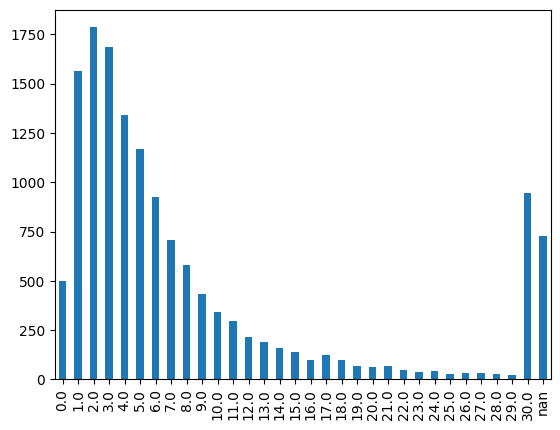

In [17]:
(
    df
    ['monthly_sales']
    .value_counts(dropna= False)
    .sort_index()
    .plot(kind='bar')

)

In [18]:
import seaborn as sns
import numpy as np

In [19]:
pt= (
    df
    .pivot_table(
        index= 'date',
        columns= 'unique_id',
        values= 'monthly_sales',
        aggfunc='sum'
    
    )
    .replace(
        {
            0:np.nan
        }
    
    )
#     .isnull()
    .notnull()
)

<Axes: xlabel='unique_id', ylabel='date'>

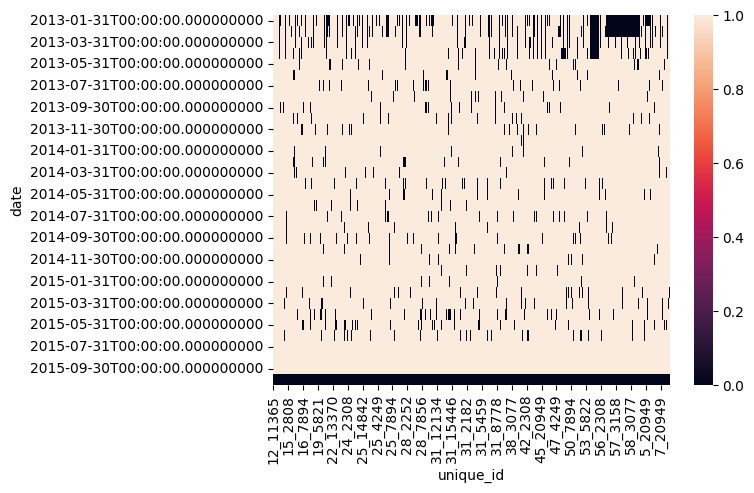

In [20]:
sns.heatmap(pt)

**Importante esto:** comprobar si mis series temporales estan completas (todos productos y todas las fechas, están todas las combinaciones) 

**Por eso chequeo fundamental:**

In [21]:
df.shape

(14484, 8)

In [22]:
df['unique_id'].nunique()

426

In [23]:
df['date'].nunique()

34

In [24]:
426 * 34

14484

De partida están todos los registros posible. (14484)

Aquí tenemos nuestro primer EDA, minicontacto con el dataset. **Pero mi objetivo inicial** es tener un codigo que yo pueda correr de principio a fin, 1 lines(importo dataset), última (predicción)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14484 non-null  datetime64[ns]
 1   unique_id              14484 non-null  object        
 2   city_id                14484 non-null  int64         
 3   shop_id                14484 non-null  int64         
 4   item_category_id       14484 non-null  int64         
 5   item_id                14484 non-null  int64         
 6   monthly_average_price  13262 non-null  float64       
 7   monthly_sales          13756 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1018.4+ KB


In [26]:
# mes com mayor numero de ventas
ventas_mes = df.groupby('date')['monthly_sales'].sum().reset_index()
ventas_mes.sort_values('monthly_sales', ascending= False)

,date,monthly_sales
23,2014-12-31,4874.0
11,2013-12-31,4514.0
24,2015-01-31,4223.0
22,2014-11-30,3681.0
12,2014-01-31,3508.0
13,2014-02-28,3462.0
25,2015-02-28,3436.0
14,2014-03-31,3383.0
19,2014-08-31,3309.0
26,2015-03-31,3245.0


In [27]:
# id de la ciudad con mayores ventas

ventas_ciudad = df.groupby('city_id')['monthly_sales'].sum().reset_index()
ventas_ciudad.sort_values('monthly_sales', ascending= False)

,city_id,monthly_sales
7,7,41360.0
22,22,7263.0
16,16,6593.0
21,21,5760.0
14,14,4437.0
18,18,3296.0
6,6,3051.0
13,13,2706.0
2,2,2659.0
11,11,2410.0


In [28]:
# id de la categoria con mayores ingresos, en septiembre de 2015
(
    df
    [df['date']=='2015-09-30']
    .groupby(['date','item_category_id'])
    ['monthly_average_price'].sum()
    .reset_index()
    .sort_values('monthly_average_price', ascending= False)





)


,date,item_category_id,monthly_average_price
10,2015-09-30,35,127430.078571
1,2015-09-30,6,77480.816667
8,2015-09-30,30,36959.437500
24,2015-09-30,75,25380.000000
0,2015-09-30,2,25170.000000
7,2015-09-30,28,23804.425000
6,2015-09-30,23,21672.746333
23,2015-09-30,73,21259.583333
26,2015-09-30,79,15675.512213
16,2015-09-30,55,10414.000000


In [29]:
# id de la categoria que tiene un mayor numero de items id diferentes 

(
    df
    .groupby('item_category_id')
    ['item_id'].nunique()
    .reset_index()
    .sort_values('item_id', ascending= False)
    




)

,item_category_id,item_id
12,40,24
16,55,19
8,30,12
14,49,9
20,65,8
18,63,7
9,31,6
24,75,5
6,23,5
2,9,4


In [30]:
# media movil de 3 meses (todas las ventas) es de:

dfgb1=(
    df
    .groupby('date')
    ['monthly_sales']
    .sum()
    .reset_index()
    
)


dfgb1['monthly_sales_ma_3'] =(
    dfgb1['monthly_sales']
    .rolling(window = 3)
    .mean()
)
dfgb1.head()


,date,monthly_sales,monthly_sales_ma_3
0,2013-01-31,2303.0,NaN
1,2013-02-28,2218.0,NaN
2,2013-03-31,2782.0,2434.333333
3,2013-04-30,2374.0,2458.000000
4,2013-05-31,2665.0,2607.000000


### --> 1. EDAD:Global Sales

In [31]:
def plot_ts_acf_pacf(y,title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''

    fig = plt.figure(figsize= (12,10))
    ax1, ax2, ax3 = fig.subplots(3,1)

    ax1.plot(y)
    plot_acf(x=y, ax=ax2, lags= 14)
    plot_pacf(x= y, ax= ax3, lags = 14)

    plt.suptitle(t= title, fontsize= 20)
    

In [32]:
y = (
    df
    .set_index('date')
    .resample('M')
    ['monthly_sales']
    .sum()
    [:-1] # quitamos los registros de octubre del df
)

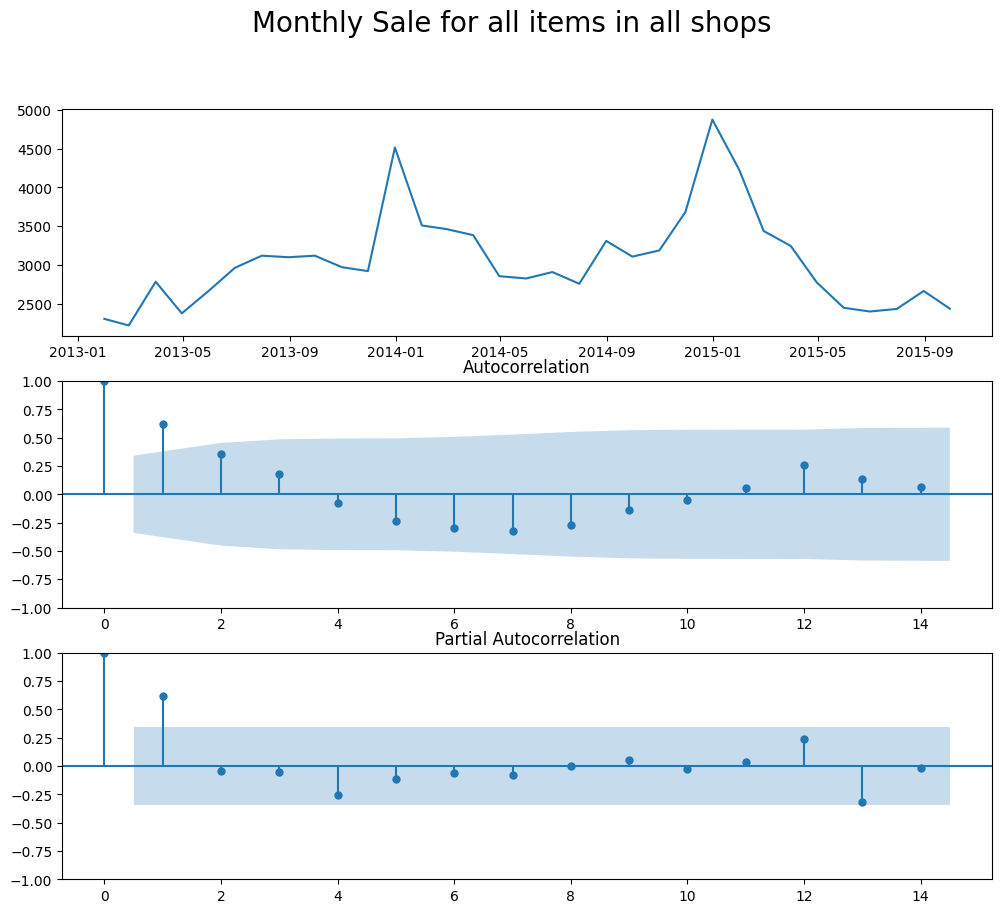

In [33]:
plot_ts_acf_pacf(y=y, title= 'Monthly Sale for all items in all shops');

In [34]:
resultado_análisis = adfuller(y)
valor_estadistico_adf = round(resultado_análisis[0],3)
p_valor= round(resultado_análisis[1],3)

print(f'Valor estadístico de ADF de las tablas precalcudas:\n {resultado_análisis[4]}\n')
print(f'Valor estadístico de ADF: {valor_estadistico_adf}\n')

print('-'*50)

print(f' Nivel de significación para tomar la serie como estacionaria: {0.05}\n')
print(f'p_valor: {p_valor}')

Valor estadístico de ADF de las tablas precalcudas:
 {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}

Valor estadístico de ADF: -4.225

--------------------------------------------------
 Nivel de significación para tomar la serie como estacionaria: 0.05

p_valor: 0.001


**Nota importante:** nos estamos ayudando del gráfico de acf y pacf, pero no vamos a entrenar un modelo ARIMA.

Para resolver el problema que se nos plantea: más de 400 Series Temporales diferentes tendríamos que entrenar 400 ARIMAs (1 modelo por Serie Temporal). En cambio, con el algoritmo de XGBoost podríamos entrenar 1 único modelo.

Ahora bien, al contrario que ARIMA (que internamente construye las variables necesarias), para XGBoost debemos ser explícitos y suministrarle todas y cada una de las variables necesarias.

Del gráfico anterior ya podemos observar que las variables de lags pueden ser muy relevantes.

IDEA para los alumnos: podéis intentar analizar algunas de las 400 Series Temporales de manera individual para ver su comportamiento.

### --->2. EDA: Top 3 Cities

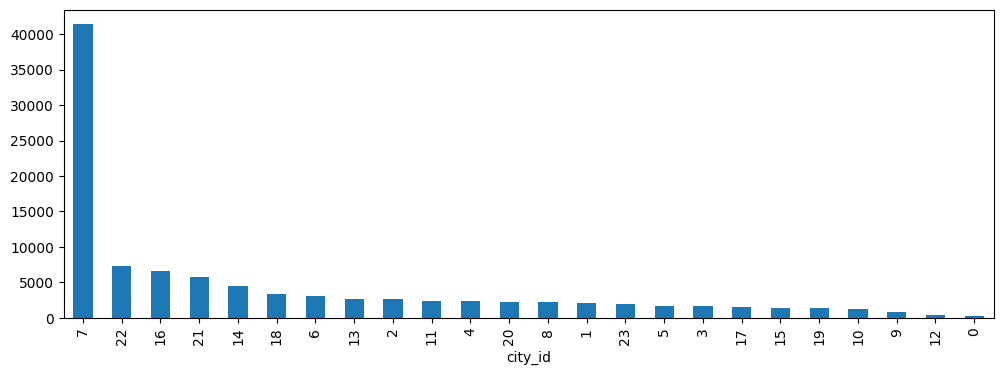

In [35]:
(
    df.groupby(['city_id'])
    ['monthly_sales'].sum()
    .sort_values(ascending=False)
    .plot(kind='bar', figsize=(12,4))
);

### --->3. EDA: Top 3 Item categories

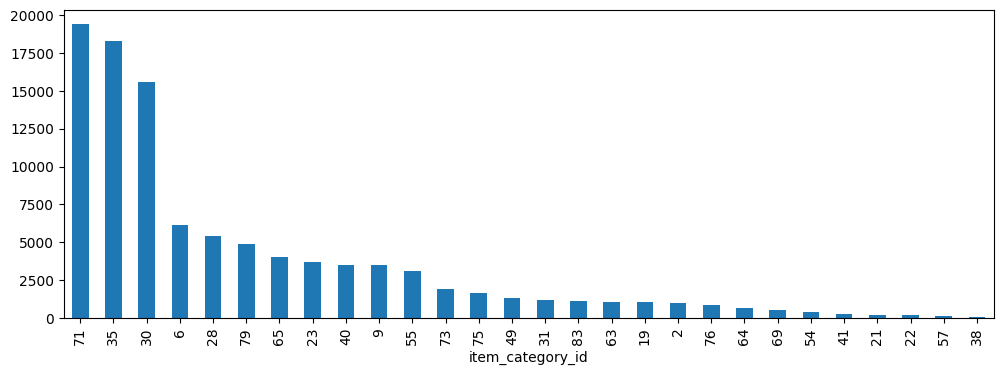

In [36]:
(
    df.groupby(['item_category_id'])
    ['monthly_sales'].sum()
    .sort_values(ascending=False)
    .plot(kind='bar', figsize=(12,4))
);

### --->4. EDA: Meses con más ventas

In [37]:
(
    df[df['date']<'2015-01-31'].groupby('date')
    ['monthly_sales'].sum()
    .sort_values(ascending=False)
)

date
2014-12-31    4874.0
2013-12-31    4514.0
2014-11-30    3681.0
2014-01-31    3508.0
2014-02-28    3462.0
2014-03-31    3383.0
2014-08-31    3309.0
2014-10-31    3186.0
2013-07-31    3118.0
2013-09-30    3118.0
2014-09-30    3106.0
2013-08-31    3098.0
2013-10-31    2970.0
2013-06-30    2961.0
2013-11-30    2919.0
2014-06-30    2907.0
2014-04-30    2854.0
2014-05-31    2824.0
2013-03-31    2782.0
2014-07-31    2756.0
2013-05-31    2665.0
2013-04-30    2374.0
2013-01-31    2303.0
2013-02-28    2218.0
Name: monthly_sales, dtype: float64

In [38]:
# Extraer mes
df['month'] = df['date'].dt.month

# Codificar de forma circular
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [39]:
# meses bajos y altos de ventas
df['is_low_month'] = df['month'].apply(lambda m: 1 if m in [2,4,5] else 0)
df['is_high_month'] = df['month'].apply(lambda m: 1 if m in [12] else 0)

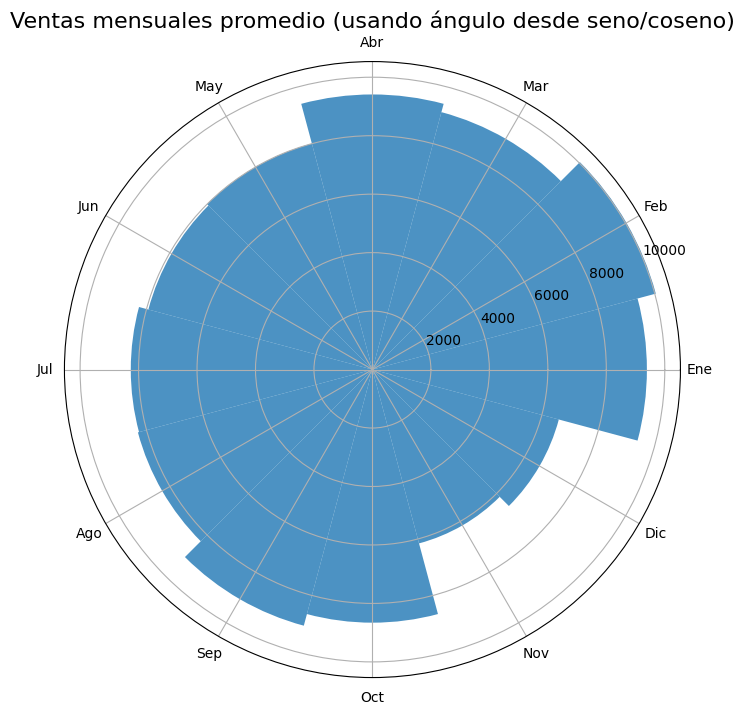

In [40]:
# Asegúrate de tener una fila por mes con sus ventas y seno/coseno ya calculados
ventas_por_mes = df.groupby('month')[['monthly_sales', 'month_sin', 'month_cos']].sum()

# Calcular ángulo a partir de seno y coseno
ventas_por_mes['angle'] = np.arctan2(ventas_por_mes['month_sin'], ventas_por_mes['month_cos'])
ventas_por_mes['angle'] = (ventas_por_mes['angle'] + 2 * np.pi) % (2 * np.pi)  # para tenerlo entre 0 y 2pi

# Crear gráfico polar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

bars = ax.bar(
    ventas_por_mes['angle'],
    ventas_por_mes['monthly_sales'],
    width=2*np.pi/12,
    align='center',
    alpha=0.8
)

# Establecer etiquetas de los meses en su ángulo correcto
month_labels = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']
month_angles = 2 * np.pi * (np.arange(12)) / 12
ax.set_xticks(month_angles)
ax.set_xticklabels(month_labels)

ax.set_title('Ventas mensuales promedio (usando ángulo desde seno/coseno)', fontsize=16)

plt.show()

### --->5. EDA: Meses con más ganancias

In [41]:
df['revenue']=df['monthly_average_price']*df['monthly_sales']

In [42]:
y = (
    df
    .set_index('date')
    .resample('M')
    ['revenue']
    .sum()
    [:-1] # quitamos los registros de octubre del df
)

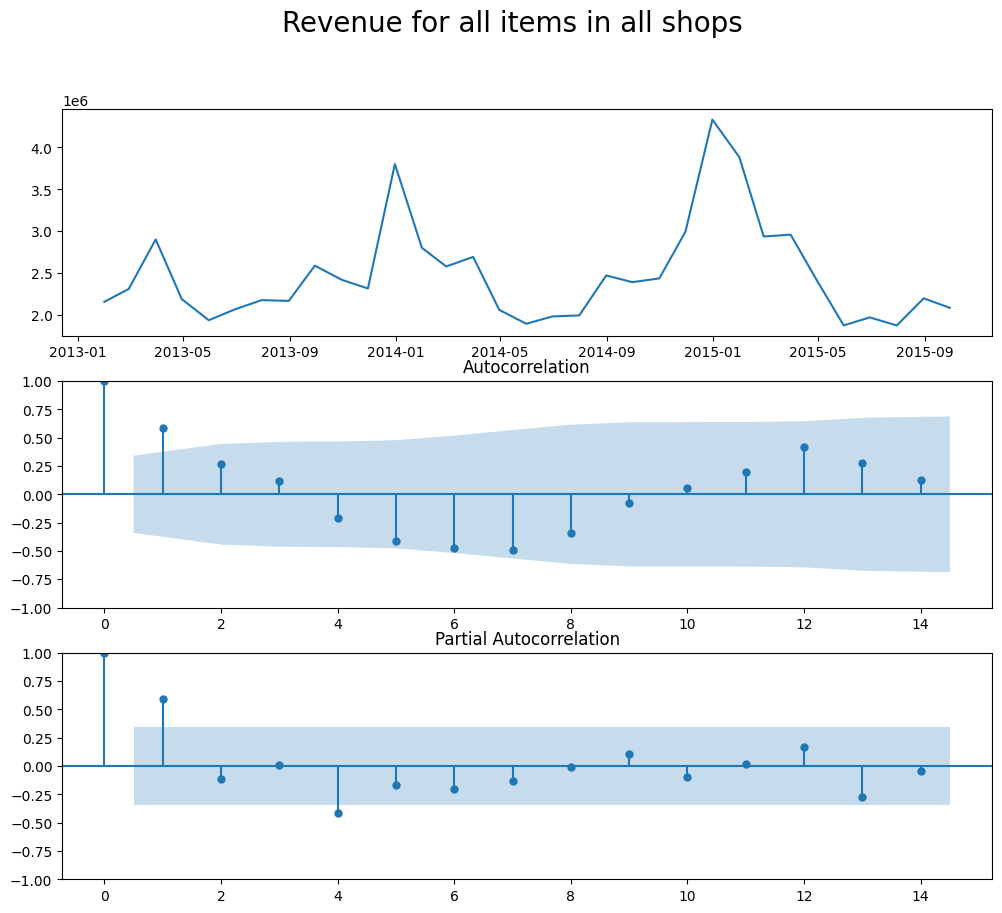

In [43]:
plot_ts_acf_pacf(y=y, title= 'Revenue for all items in all shops');

### --->6. EDA: Meses con más gprecio medio 

In [44]:
y = (
    df
    .set_index('date')
    .resample('M')
    ['monthly_average_price']
    .sum()
    [:-1] # quitamos los registros de octubre del df
)

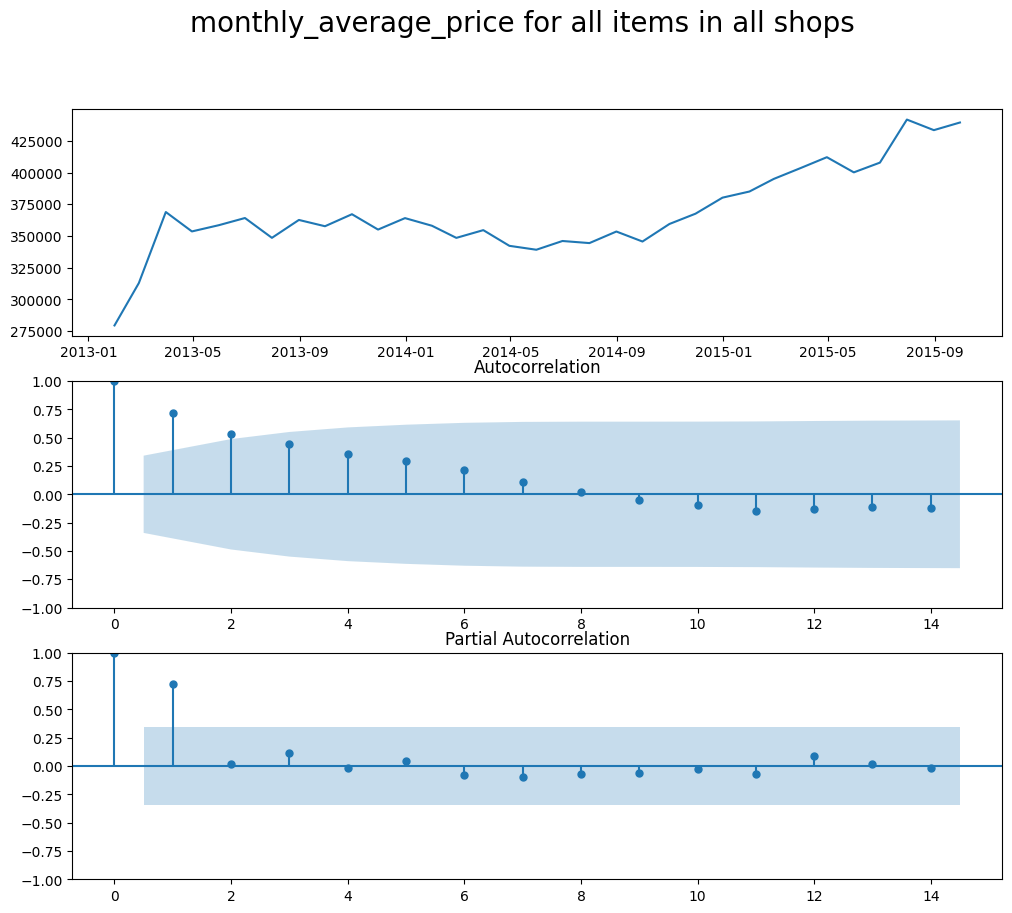

In [45]:
plot_ts_acf_pacf(y=y, title= 'monthly_average_price for all items in all shops');

In [46]:
y = (
    df[df['item_category_id'] == 2] 
    .set_index('date')
    .resample('M')
    ['revenue']
    .sum()
    [:-1] # quitamos los registros de octubre del df
)

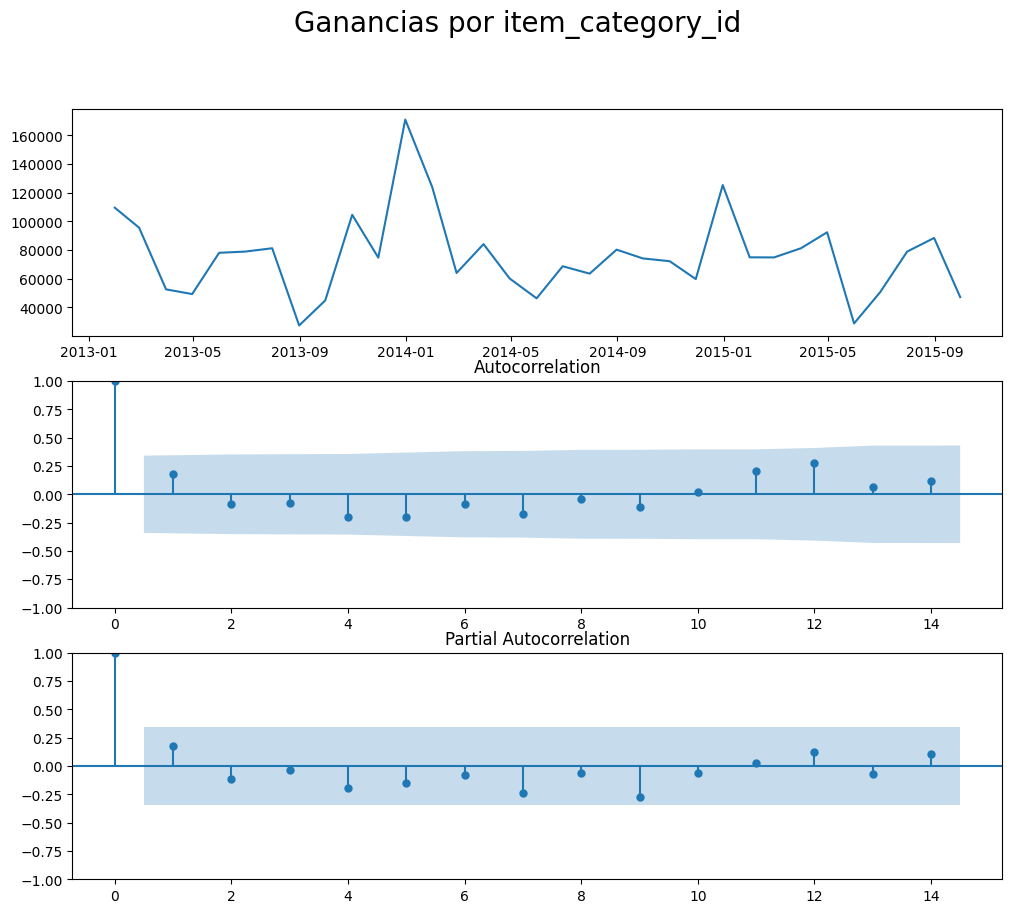

In [47]:
plot_ts_acf_pacf(y=y, title= 'Ganancias por item_category_id ');

### --->7. EDA: item_category_id

In [48]:
(
    df
    .groupby('item_category_id')['monthly_sales']
    .sum()
    .to_frame()
    .reset_index()
    .sort_values('monthly_sales', ascending= True)
)

,item_category_id,monthly_sales
11,38,79.0
17,57,127.0
5,22,161.0
4,21,178.0
13,41,242.0
15,54,373.0
21,69,521.0
19,64,656.0
25,76,870.0
0,2,984.0


### --->8. EDA: item_id

In [49]:
(
    df
    .groupby('item_id')['monthly_sales']
    .sum()
    .to_frame()
    .reset_index()
    .sort_values('monthly_sales', ascending= True)
)

,item_id,monthly_sales
84,12558,49.0
129,21445,56.0
63,10334,56.0
29,3656,62.0
43,6351,67.0
...,...,...
52,7856,4231.0
115,17717,4852.0
16,2308,5266.0
40,5822,10048.0


### --> 9_ City_id

In [54]:
(
    df
    .groupby('city_id')['monthly_sales']
    .sum()
    .to_frame()
    .reset_index()
    .sort_values('monthly_sales', ascending= True)
)

,city_id,monthly_sales
0,0,246.0
12,12,467.0
9,9,878.0
10,10,1280.0
19,19,1398.0
15,15,1425.0
17,17,1492.0
3,3,1674.0
5,5,1737.0
23,23,2001.0


## Correlacion

In [50]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\miiki\AppData\Local\Temp\ipykernel_19860\3784545759.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,month,month_sin,month_cos,is_low_month,is_high_month,revenue
city_id,1.000000,0.392969,-0.070485,-0.031600,-0.059745,0.041934,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.014720
shop_id,0.392969,1.000000,-0.063615,-0.006660,-0.082720,-0.056214,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.085218
item_category_id,-0.070485,-0.063615,1.000000,0.538650,-0.247932,0.236070,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.072817
item_id,-0.031600,-0.006660,0.538650,1.000000,-0.341573,0.305838,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.171163
monthly_average_price,-0.059745,-0.082720,-0.247932,-0.341573,1.000000,-0.122663,-0.016648,0.013086,-0.009227,0.009446,-0.010555,0.564996
monthly_sales,0.041934,-0.056214,0.236070,0.305838,-0.122663,1.000000,0.025421,0.016160,0.120260,-0.045217,0.119502,0.446190
month,0.000000,0.000000,-0.000000,0.000000,-0.016648,0.025421,1.000000,-0.793582,0.103424,-0.458407,0.435841,-0.001896
month_sin,-0.000000,-0.000000,-0.000000,-0.000000,0.013086,0.016160,-0.793582,1.000000,0.027203,0.605751,-0.005089,0.042114
month_cos,-0.000000,-0.000000,0.000000,-0.000000,-0.009227,0.120260,0.103424,0.027203,1.000000,-0.203548,0.382675,0.119589
is_low_month,0.000000,0.000000,-0.000000,-0.000000,0.009446,-0.045217,-0.458407,0.605751,-0.203548,1.000000,-0.150000,-0.026953


In [51]:
# Si tenemos muchas variables eliminamos duplicidad
corr2= corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
corr2
corr3= corr2.unstack().dropna().sort_values(ascending= False)
corr3.head(20)

is_low_month   month_sin                0.605751
revenue        monthly_average_price    0.564996
item_id        item_category_id         0.538650
revenue        monthly_sales            0.446190
is_high_month  month                    0.435841
shop_id        city_id                  0.392969
is_high_month  month_cos                0.382675
monthly_sales  item_id                  0.305838
               item_category_id         0.236070
month_cos      monthly_sales            0.120260
revenue        month_cos                0.119589
is_high_month  monthly_sales            0.119502
month_cos      month                    0.103424
revenue        is_high_month            0.096962
               month_sin                0.042114
monthly_sales  city_id                  0.041934
month_cos      month_sin                0.027203
month          monthly_sales            0.025421
month_sin      monthly_sales            0.016160
               monthly_average_price    0.013086
dtype: float64